# Aplicação do Algoritmo de clusterização Kmeans: análise exploratória dos dados e modelagem

# Início

O dataset presente carrega informações físicas de espécies de peixes. Para finalidade do exercício, será deletada a coluna que carrega a informação de qual espécie é aquele peixe para tornar o exercício não supervisionado.

As variáveis são:
- Weight (peso)
- Lenght 1 (comprimento 1)
- Lenght 2 (comprimento 2)
- Lenght 3 (comprimento 3)
- Height (altura)
- Width (largura)

Realizaremos as análises estatísticas inicias, em que iremos conferir a importação e realizar quaisquer correções necessárias nos dados. Em seguida partiremos para uma análise exploratória e por fim iremos ao modelo e suas conclusões.

## Análise estatística inicial

In [1]:
import pandas as pd

In [2]:
df_ = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/Fish.csv')

In [3]:
df_.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


Com o import correto, vamos agora tirar a coluna que traz a informação de que peixe é:

In [4]:
df = df_.drop(['Species'], axis=1)

In [5]:
df.head()

,Weight,Length1,Length2,Length3,Height,Width
0,242.0,23.2,25.4,30.0,11.5200,4.0200
1,290.0,24.0,26.3,31.2,12.4800,4.3056
2,340.0,23.9,26.5,31.1,12.3778,4.6961
3,363.0,26.3,29.0,33.5,12.7300,4.4555
4,430.0,26.5,29.0,34.0,12.4440,5.1340


Perfeito, vamos as análises iniciais:

In [6]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,398.326415,26.247170,28.415723,31.227044,8.970994,4.417486
std,357.978317,9.996441,10.716328,11.610246,4.286208,1.685804
min,0.000000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,120.000000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,273.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


Ok, vamos primeiro ao que está aparentemente certo e depois vamos observar o que parece equivocado:

- As variávis Lenght 1,2 e 3 têm um máximo e mínimo razoáveis, mesmo sem uma escala;
- Apesar de não entender como se mede a 'altura' de um peixe, a variável height traz um intervalo razoável também, assim como a variável Width
- O dataset não aparenta ter dados faltantes também

Agora vamos ao que não parece correto: o valor mínimo da variável Weight (peso) é zero: um peixe não pode não pesar nada. Vamos investigar se esse caso é único ou se se repete:

In [7]:
df.query('Weight == 0')['Weight'].count()

1

O caso é único, vamos ver a linha em que se encontra:

In [8]:
df.loc[df['Weight'] == 0]

,Weight,Length1,Length2,Length3,Height,Width
40,0.0,19.0,20.5,22.8,6.4752,3.3516


Esse é o único atributo da linha 40 que vale zero. Aqui temos várias opções a se fazer: podemos deletar a linha ou preenchê-la com algum valor. Como o dataset já é pequeno, vamos preencher o valor zerado com a média dos pesos:

In [9]:
df.loc[df['Weight'] == 0] = df.loc[df['Weight'] == 0].replace({0: df['Weight'].mean()})

In [10]:
df.Weight.min()

5.9

Deu certo.

In [11]:
df.describe()

,Weight,Length1,Length2,Length3,Height,Width
count,159.000000,159.000000,159.000000,159.000000,159.000000,159.000000
mean,400.831613,26.247170,28.415723,31.227044,8.970994,4.417486
std,356.564100,9.996441,10.716328,11.610246,4.286208,1.685804
min,5.900000,7.500000,8.400000,8.800000,1.728400,1.047600
25%,122.500000,19.050000,21.000000,23.150000,5.944800,3.385650
50%,290.000000,25.200000,27.300000,29.400000,7.786000,4.248500
75%,650.000000,32.700000,35.500000,39.650000,12.365900,5.584500
max,1650.000000,59.000000,63.400000,68.000000,18.957000,8.142000


Por desencargo de consciência, vamos ver se tem mais algum zero no dataset (não deve ter, o describe() já mostrou isso.

In [12]:
df.eq(0).any().any()

False

Não existe mais nenhum valor igual a zero. Vamos continuar.

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159 entries, 0 to 158
Data columns (total 6 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Weight   159 non-null    float64
 1   Length1  159 non-null    float64
 2   Length2  159 non-null    float64
 3   Length3  159 non-null    float64
 4   Height   159 non-null    float64
 5   Width    159 non-null    float64
dtypes: float64(6)
memory usage: 7.6 KB


In [14]:
df.isna().count()

Weight     159
Length1    159
Length2    159
Length3    159
Height     159
Width      159
dtype: int64

Sem dados faltantes. Ótimo.

Vamos agora à análise exploratória:

## Análise Exploratória

In [15]:
!pip install fitter

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for fitter: filename=fitter-1.5.2-py3-none-any.whl size=25609 sha256=89658c36e3af3497868f0255c7bd2851ab8afae16b8d6c51c696ff47e186a5a2
  Stored in directory: /root/.cache/pip/wheels/8e/6b/cb/628035771acab95dc84f200590b4838c7c3095a70ede67a25a
Successfully built fitter


In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
from fitter import Fitter, get_common_distributions, get_distributions
from matplotlib import rcParams

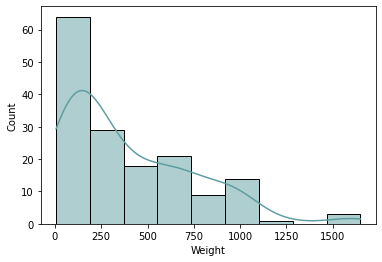

In [17]:
sns.histplot(data=df, x="Weight", color='cadetblue', kde=True)

Interessante, a curva que melhor representa os dados de peso dos peixes é uma exponencial, não uma normal que geralmente aparece. Na verdade vamos adiante explorar para ver qual curva melhor (dada algumas opções, se não demora muito para rodar) se adpata a esses dados. Seguindo,

Desse gráfico podemos abstrair que a maioria dos peixes pesa entre 0 e 250 e a quantidade de peixes vai diminuindo conforme vamos aumentando seu peso. Acredito que faça sentido, suponho ter mais peixes "leves" e menores no mar que os grandes e pesados. 

O peso deve ser uma variável que dialoga com o tamanho do peixe: peixes muito leves devem ser menores e os pesados maiores. 

Vamos seguir para avaliar a melhor curva para esse gráfico:

Fitting 5 distributions: 100%|██████████| 5/5 [00:01<00:00,  4.95it/s]


,sumsquare_error,aic,bic,kl_div,ks_statistic,ks_pvalue
burr,0.000047,1644.541651,-2370.832455,inf,0.082593,2.159388e-01
beta,0.000049,1624.867979,-2364.844259,inf,0.089196,1.499060e-01
gamma,0.000050,1624.086555,-2365.154297,inf,0.087502,1.650720e-01
norm,0.000077,1685.135172,-2300.795189,inf,0.158842,5.692800e-04
lognorm,0.000096,1919.029376,-2261.525822,inf,0.618331,4.294405e-59


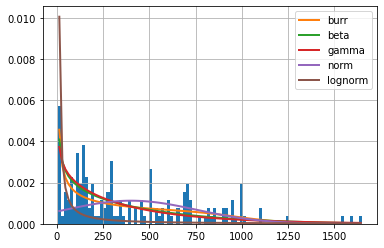

In [18]:
Weight = df["Weight"].values
f = Fitter(Weight,
           distributions=['gamma', 'lognorm', "beta", "burr", "norm"])
f.fit()
f.summary()

Apenas por curiosidade, a curva com menor sumsquare_error (soma residual dos quadrados) foi a burr.

Legal, vamos seguir:

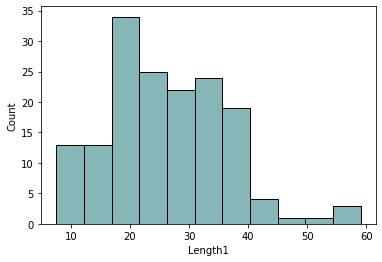

In [19]:
sns.histplot(data=df, x="Length1", color='cadetblue')

A variável Length1 já se aproxima mais de uma normal, ou seja, a maioria dos peixes tem um tamanho que oscila entre 15 e 40. Existem menos peixes muito pequenos ou muito grandes, a maioria tem um tamanho médio. Apesar desse intervalo médio ser grande, faz sentido. 

Vamos detalhar um pouco e aumentar a quantidade de intervalos:

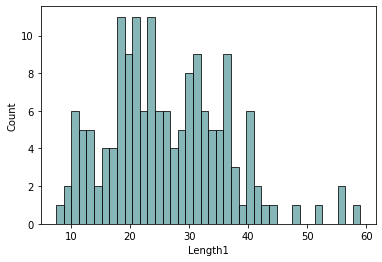

In [20]:
sns.histplot(data=df, x="Length1", bins=40, color='cadetblue')

Legal, existem 3 intervalos de peso de peixes que se repetem de maneira equivalente no dataset, ou seja, pouco mais de 10 peixes pesam algo pouco inferior a 20, pouco superior a 20 e perto de 25. Se aumentarmos o número de Bins possivelmente poderemos observar com mais detalhes, mas por hora vamos seguir:

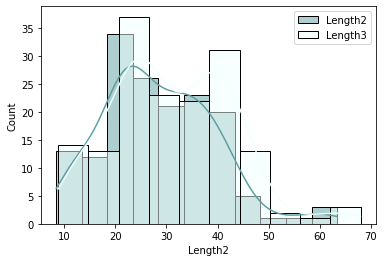

In [21]:
sns.histplot(data=df, x="Length2", color="cadetblue", label="Length2", kde=True)
sns.histplot(data=df, x="Length3", color="azure", label="Length3", kde=True)

plt.legend() 
plt.show()

Podemos observar que as variáveis Length2 e 3 "caminham" juntas e seguem uma proporcionalidade. 

Tem poucas variações e a grosso modo podemos observar que esboçam uma curva normal, em que a maioria dos peixes apresenta como Length2 e 3 um valor no intervalo de 20 a ~30. Existem menos peixes com valores muito altos e baixos para essas variáveis, mas existem mais peixes menores que maiores, de acordo com os dados.

Os tamanhos menos encontrados nos peixes são os que tem Length2 e 3 entre 50 e ~60 unidades. Peixes maiores que esse tamanho são, inclusive, mais comuns.

Vamos seguir nas análises:

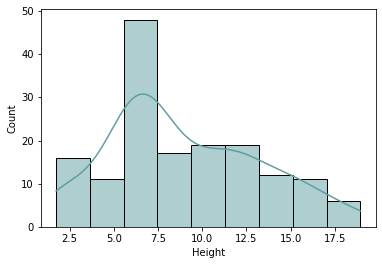

In [22]:
sns.histplot(data=df, x="Height", color='cadetblue', kde=True)

A 'altura' do peixe também esboça uma normal. As alturas de maior ocorrência nos dados estão no intervalo de 5.0 a 7.5 unidades e peixes com altura superior a 17.5 são os mais raros e tem menos no dataset.

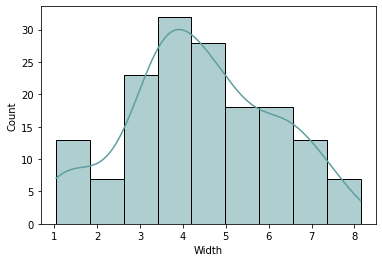

In [23]:
sns.histplot(data=df, x="Width", color='cadetblue', kde=True)

Tanto a 'altura' dos peixes quanto a 'largura' são distribuições normais em que a maioria dos dados se encontra no centro e as ocorrências vão diminuindo conforme aumentam e diminuem da mediana.

Para a altura, de 5.0 a 7.5 existem muitos peixes, e fora esses valores a distribuição é quase constante, ou seja, o número de peixes que tem altura fora desse intervalo é quase constante.

Para a variável largura, o intervalo de maior ocorrência é o de 3 a 4 unidades.

Vamos ver os gráficos de dispersão:

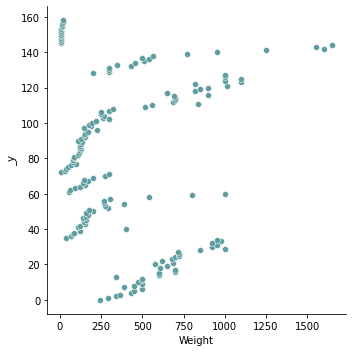

In [24]:
sns.relplot(x="Weight", y=df.Weight.index, data=df,color='cadetblue')

Olha que bacana, já é possível imaginar os dados com index até ~30 podem vir a fazer parte do mesmo cluster porquê eles já estão bem separados.

É possível inferir alguns clusters porquê os dados já estão bem separados e definidos.

Próxima variável:

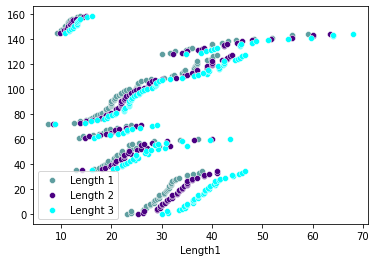

In [25]:
sns.scatterplot(x="Length1", y=df.Length1.index, data=df, label='Length 1', color='cadetblue')
sns.scatterplot(x="Length2", y=df.Length1.index, data=df, color='indigo', label='Length 2')
sns.scatterplot(x="Length3", y=df.Length1.index, data=df, label= 'Lenght 3', color='cyan')

rcParams['figure.figsize'] = 18,13
plt.legend() 
plt.show()

As variáveis de tamanho seguem a proporção uma das outras.

É possível tentar inferir os clusters antes mesmo de qualquer implementação de modelo, acredito que o modelo vai performar bem e refletir bem os dados. 

O que extraímos daqui é que os peixes localizados no dataset até o índice ~20 tem as variáveis comprimento 1,2 e 3 variando entre ~20 a ~45 unidades. O eixo y do gráfico é o índice do dataset. Aparentemente os dados foram inseridos no dataset de maneira não-aleatória, inclusive. Até porquê os últimos dados (seriam os peixes mais acima no gráfico) na base são os peixes que apresentam menor tamanho, variando entre ~10 e ~20 unidades

Aparentemente, existem 6 possibilidades aí, cada um com as seguintes coordenadas APROXIMADAS (Lenght1 (tamanho) x index):
- 35x20
- 25x45
- 20x60
- 35x100
- 50x140
- 15x150

Os dados já parecem estar separados e homogêneos até, bacana. 

Próxima variável:

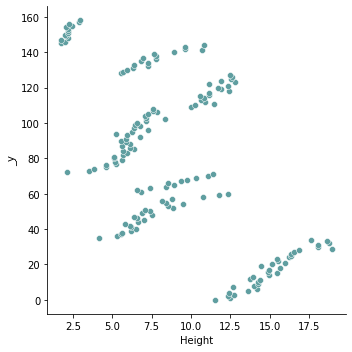

In [26]:
sns.relplot(x="Height", y=df.Height.index, data=df, color='cadetblue')

O mesmo comportamente se reflete para a 'altura' do peixe, em que parece que agora temos 6 divisões também. O número de clusters que irei inferir será de 6 portanto.

A ver, os peixes com índice abaixo de ~35 são os mais pesados do dataset enquanto que os últimos da base são os mais leve, além de serem os menores em comprimento.

Isso reforça que a inserção dos dados no df não foi feita de maneira aleatória: primeiro se inseriu um grupo de peixes, grandes, pesados e 'altos', depois peixes médios em tudo e por fim os peixes pequenos, leves e 'baixos'.

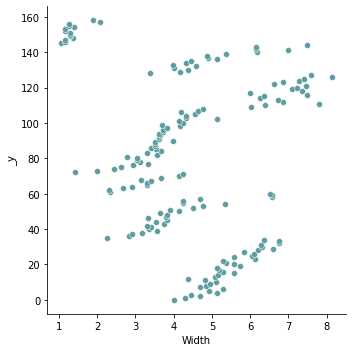

In [27]:
sns.relplot(x="Width", y=df.Width.index, data=df, color='cadetblue')

Para a variável 'largura', os dados já estão mais homogêneos e espalhados, mas ainda assim é bem possível buscar identificar segmentos entre essa dispersão, poderia ser bem pior. Aqui, é muito claro que pode vir a ter um centróide na coordenada ~5.5x20, segmentando a parte de baixo do gráfico.

Esse gráfico também reforça que os primeiros peixes são os mais largos, seguidos pelos medianos e lá em cima do gráfico, com os maiores índices temos os menos largos, os mais 'finos'.

Bem interessante: todos os gráficos de dispersão conversam entre si e nos levaram a várias hipóteses e suposições.

Vamos analisar agora uma variável relacionada a outra, ou seja, o eixo y não será mais o índice, mas sim outra variável:

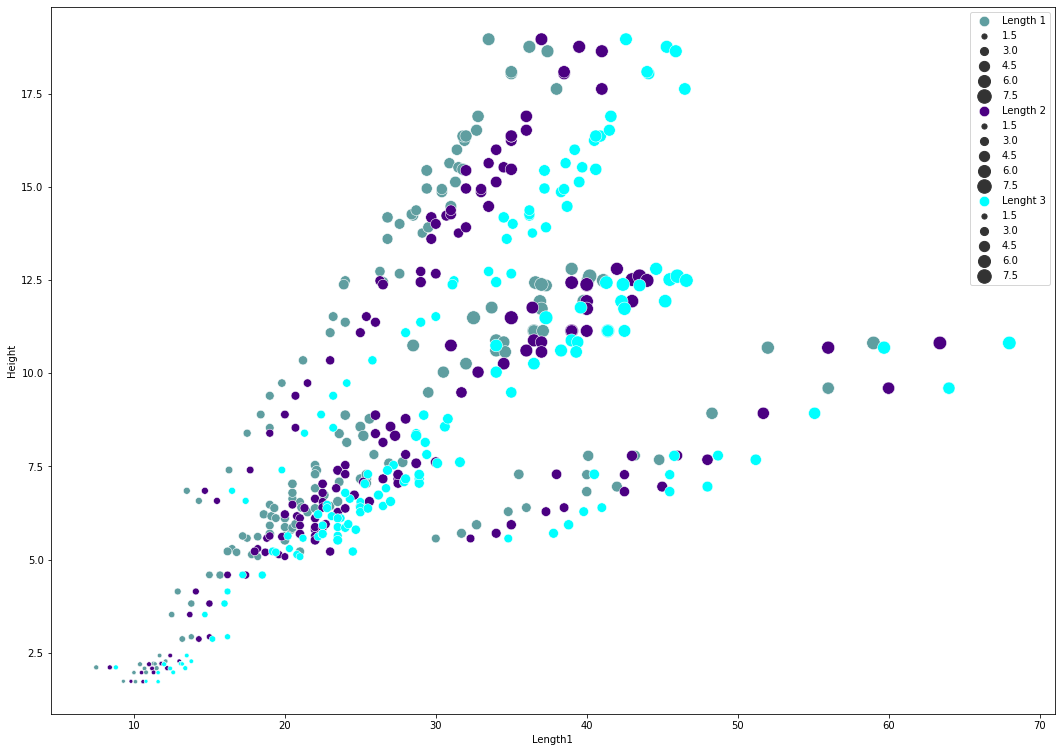

In [28]:
sns.scatterplot(x="Length1", y='Height', data=df, label='Length 1', color='cadetblue', size="Width",sizes=(15, 200))
sns.scatterplot(x="Length2", y='Height', data=df, color='indigo', label='Length 2', size="Width", sizes=(15, 200))
sns.scatterplot(x="Length3", y='Height', data=df, label= 'Lenght 3', color='cyan', size="Width", sizes=(15, 200))

rcParams['figure.figsize'] = 18,13
plt.legend() 
plt.show()

Vamos entender o gráfico e depois analisá-lo:

No eixo X temos o comprimento que, mesmo tendo 3 colunas para essa informação, tem a mesma ordem de grandeza.
No eixo y, temos a altura.
As cores diferem os 3 tipos de comprimento e por fim o tamanho do ponto traz a informação da largura.

É um gráfico bem completo e podemos concluir e confirmar várias suspeitas e informações que vinham aparecendo.

- O fato dos pontos pequenos de diferentes cores e pontos médios e grandes estarem juntos no gráfico mostra que a largura é bem heterogênea (no ponto de vista de todas as larguras), ou seja, os dados estão bem separados (e com isso os 'clusters' de largura seriam homogêneos) já em grupos de características matemáticas parecidas.

- As informações de comprimentos se conversam e parecem formar 3 retas lineares distintas, o que mostra que não apenas essas variáveis parecem heterogêneas como elas relacionadas a altura (eixo y) também.

Além disso, conforme aumentamos o comprimento, aumentamos a 'altura' e aumenta o peso. Tudo super fazendo sentido.

Vamos ver agora mais um gráfico:

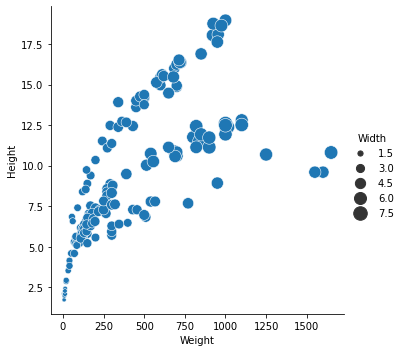

In [29]:
sns.relplot(x="Weight", y="Height", size="Width", sizes=(15, 200), data=df)

O peso x altura x largura tem uma certa separação já, mas não tão clara quanto o gráfico acima dos comprimentos. 

As mesmas 3 divisões ocorrem conforme aumentamos o peso e altura, formando 3 diferentes segmentos de dados. Conforme aumentamos a altura e o peso, a largura aumenta também, tudo faz sentido.

Vamos ver a correlação entre essas variáveis:

In [30]:
cor= df.corr()
cor

,Weight,Length1,Length2,Length3,Height,Width
Weight,1.000000,0.914218,0.917039,0.921573,0.723101,0.885552
Length1,0.914218,1.000000,0.999517,0.992031,0.625378,0.867050
Length2,0.917039,0.999517,1.000000,0.994103,0.640441,0.873547
Length3,0.921573,0.992031,0.994103,1.000000,0.703409,0.878520
Height,0.723101,0.625378,0.640441,0.703409,1.000000,0.792881
Width,0.885552,0.867050,0.873547,0.878520,0.792881,1.000000


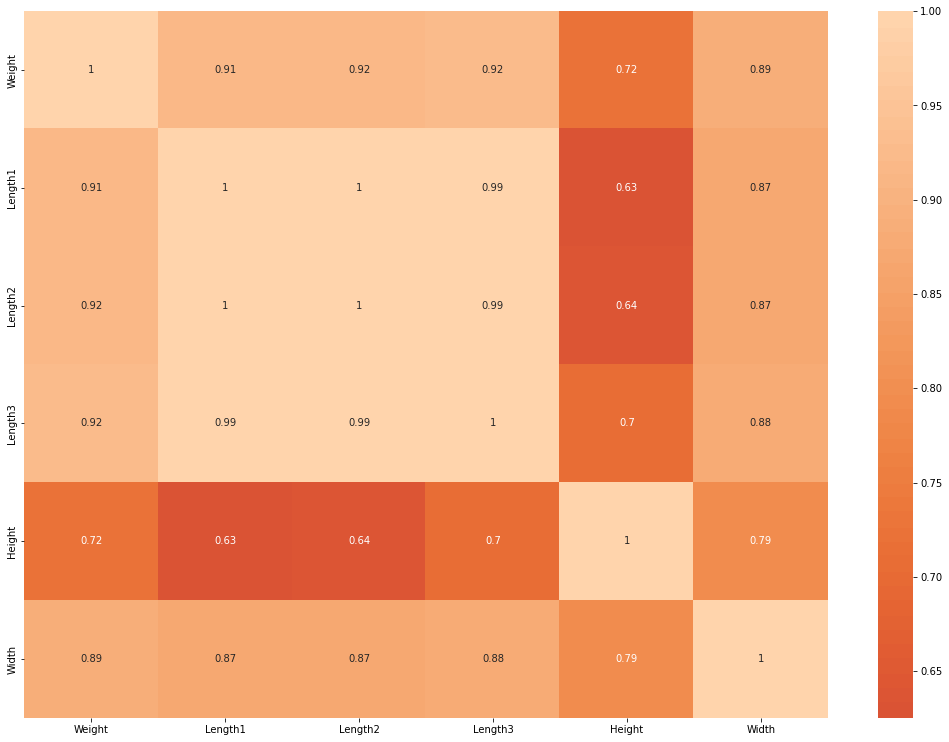

In [31]:
sns.heatmap(cor, center=0, annot=True)

Se o modelo a ser criado fosse supervisionado, seria o caso de deletar, ou pelo menos não considerar no modelo, algumas variáveis:

A correlação entre os comprimentos é muito grande, é quase igual e isso afeta a acurácia e dificulta a análise em algorimtos supervisionados. Quanto mais perto de 1 a correlação entre duas variáveis, mais diretamente proporcionais elas são e correlatas. Quanto mais perto de -1, mais inversamente proporcionais elas são, ainda que correlatas. Lembrando apenas que essa relação não indica causalidade!
 
Isso é algo bom quando comparamos uma feature qualquer com a variável target em modelos superviosados, mas altas correlações em variáveis que não a target não ajudam o modelo.

De qualquer forma, o fato da correlação entre as variáveis de comprimeto ser enorme foi refletido nos gráficos, são praticamente os mesmos dados. O que a correlação procura entender é como uma variável se comporta em um cenário onde outra está variando, visando identificar se existe alguma relação entre a variabilidade de ambas. No caso dos nossos dados, o comportamento das variáveis é muito parecido entre si.

De fato, se um peixe é maior em comprimento, é de se esperar que ele também seja mais 'alto' e mais pesado. Por isso a correlalção altíssima entre as variáveis. Da mesma maneira, peixes menores são mais leves e menores. Tudo explicado fazendo sentido.

Até mesmo as outras variáveis tem altíssimas correlações: a menor é de 0.63, que já é alto. Isso mostra que os dados tem uma alta proporcionalidade:

- se aumentarmos o comprimento, o peso e a 'altura' vão aumentar. E o inverso é também verdadeiro.

Vamos ao modelo agora:

## Modelo

In [32]:
from sklearn.cluster import KMeans 

Como visualmente para haver 6 separações, vamos usar o n = 6, como dito anteriormente.

In [33]:
kmeans = KMeans(n_clusters = 6) 
pred_y = kmeans.fit_predict(df)
df['clusters'] = pred_y

Criamos uma coluna extra com o agrupamento, vamos ver se funcionou:

In [34]:
df.head()

,Weight,Length1,Length2,Length3,Height,Width,clusters
0,242.0,23.2,25.4,30.0,11.5200,4.0200,0
1,290.0,24.0,26.3,31.2,12.4800,4.3056,0
2,340.0,23.9,26.5,31.1,12.3778,4.6961,0
3,363.0,26.3,29.0,33.5,12.7300,4.4555,0
4,430.0,26.5,29.0,34.0,12.4440,5.1340,2


In [35]:
df.clusters.value_counts()

3    63
0    33
2    22
5    21
1    17
4     3
Name: clusters, dtype: int64

Aparentemente 6 segmentações foi muito, a ver por conta do cluster = 3, que te apenas 3 representantes. Talvez esse terceiro cluster pudesse ser alocado em outros.

Vamos ver graficamente:

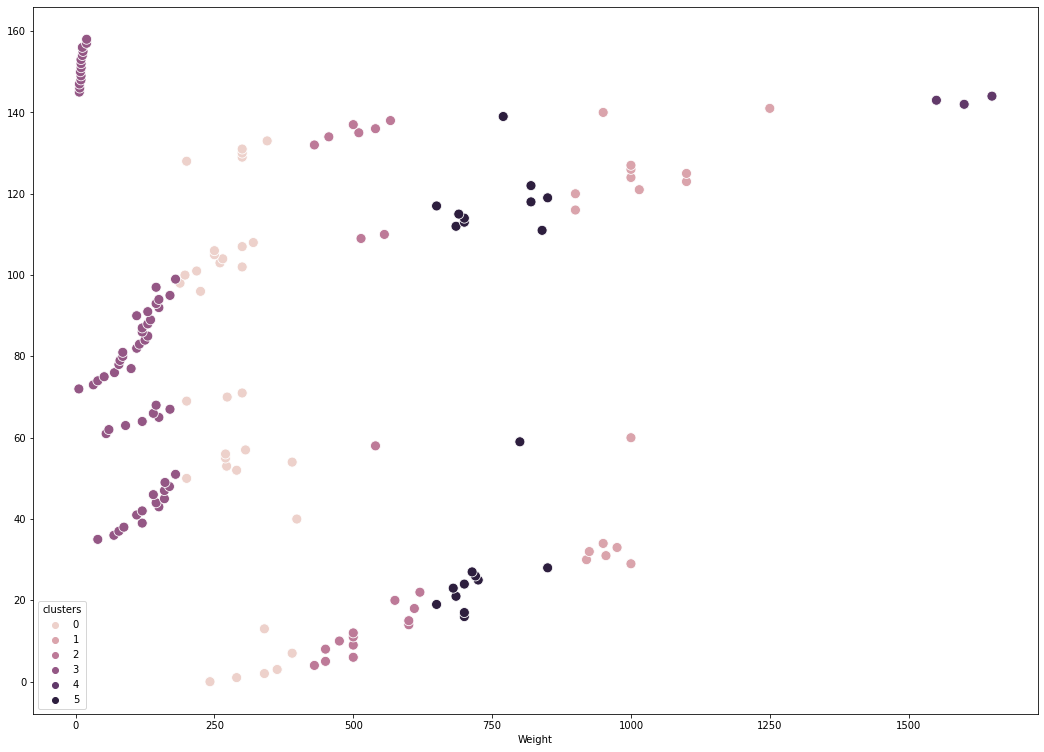

In [36]:
sns.scatterplot(data=df, x="Weight", y=df.index, hue="clusters", s=100)

Vamos tentar com n = 4:

In [37]:
kmeans = KMeans(n_clusters = 4) 
pred_y = kmeans.fit_predict(df)
df['clusters'] = pred_y

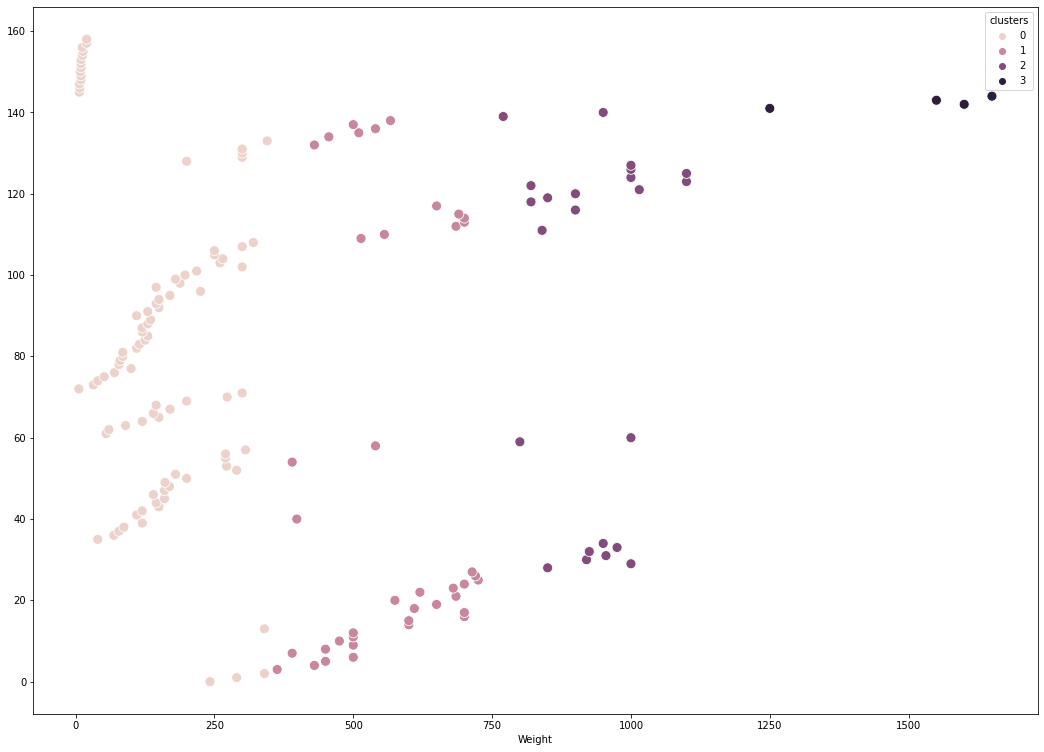

In [38]:
sns.scatterplot(data=df, x="Weight", y=df.index, hue="clusters", s=100)

Talvez dê para clusterizar ainda mais: vamos tentar com 3, que seriam peixes pequenos, médios e grandes:

In [39]:
kmeans = KMeans(n_clusters = 3) 
pred_y = kmeans.fit_predict(df)
df['clusters'] = pred_y

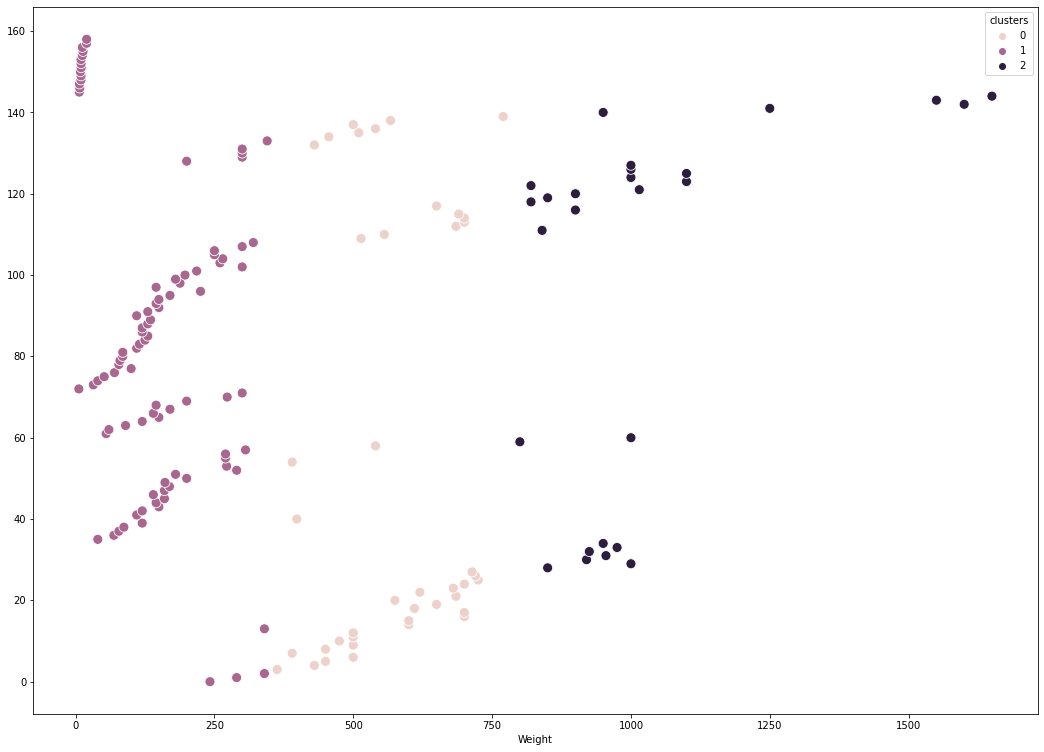

In [40]:
sns.scatterplot(data=df, x="Weight", y=df.index, hue="clusters", s=100)

Acho que assim ficou melhor, parece haver 3 distinções muito claras: peixes leves, com peso menor que ~275 unidades, peixes médios, menores que ~775 unidades e peixes pesados, pesando mais que ~775.


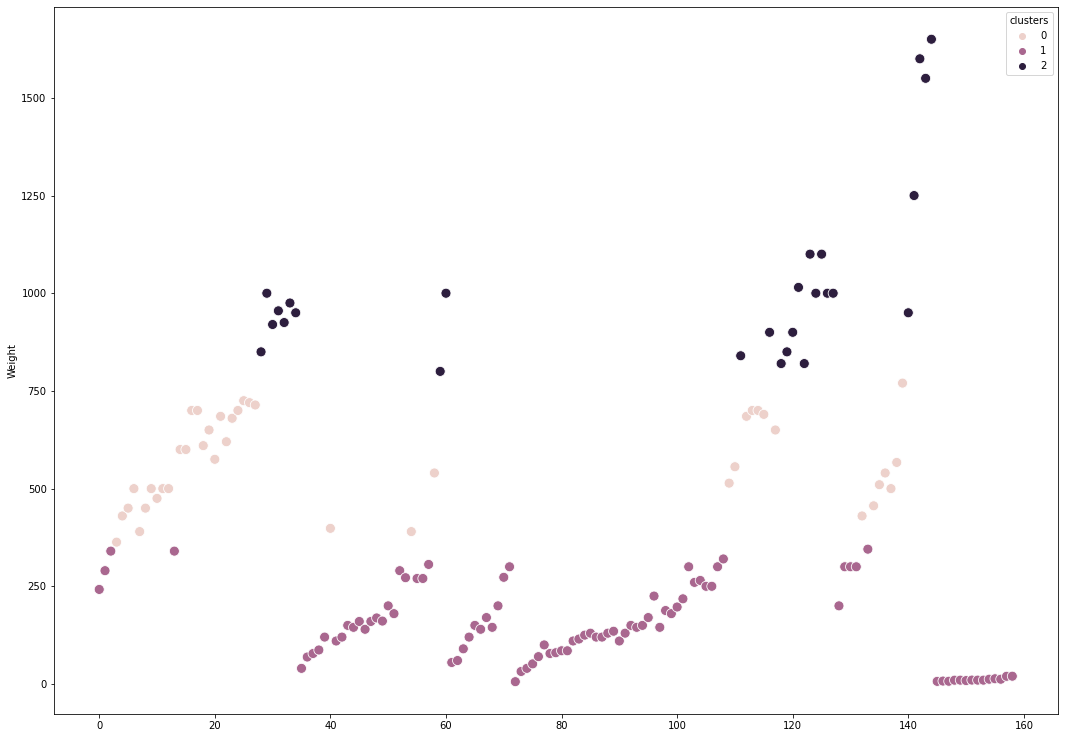

In [41]:
sns.scatterplot(data=df, x=df.index, y="Weight", hue="clusters", s=100)

Esse gráfico ficou mais claro mostrar os peixes pequenos e leves, médios e médio pesados e grandes e pesados.

Vamos seguir com n = 3.
Vamos observar as outras variáveis.

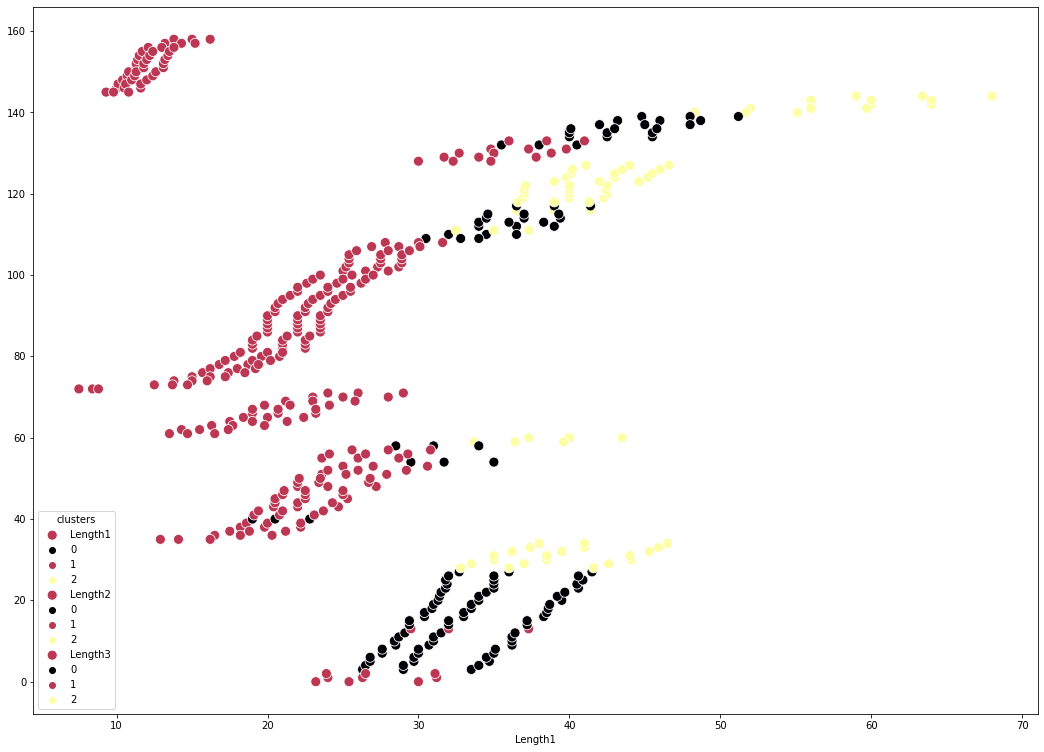

In [42]:
sns.scatterplot(data=df, x="Length1", y=df.index, hue="clusters", label="Length1", palette="inferno",  s=100)
sns.scatterplot(data=df, x="Length2", y=df.index, hue="clusters", label="Length2", palette="inferno",  s=100)
sns.scatterplot(data=df, x="Length3", y=df.index, hue="clusters", label="Length3",palette="inferno" , s=100)

O padrão se repete para os comprimentos: o primeiro cluster traz os peixes mais leves e menores, o segundo se entrelaça um pouco com o terceiro, mas no geral traz os peixes médio-pesados e de tamanho mediano e o último cluster, por fim, traz os peixes mais pesados e maiores portanto. Faz total sentido o peso, o comprimento, a altura e a largura serem diretamente proporcionais.

Vamos agora comparar nossa clusterização com os dados verdadeiros:

In [43]:
# dataset manipulado e com os clusters
df.head(2)

,Weight,Length1,Length2,Length3,Height,Width,clusters
0,242.0,23.2,25.4,30.0,11.52,4.0200,1
1,290.0,24.0,26.3,31.2,12.48,4.3056,1


In [44]:
# dataset original
df_.head()

,Species,Weight,Length1,Length2,Length3,Height,Width
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340


Vamos ver quantas espécies tem o dataset original e se nossa inferência de k's foi assertiva:

In [45]:
df_['Species'].value_counts()

Perch        56
Bream        35
Roach        20
Pike         17
Smelt        14
Parkki       11
Whitefish     6
Name: Species, dtype: int64

Tinha 7 tipos de peixe: no fim separar em pequenos, médios e grandes foi muito simplista.

Vamos apenas para comparar criar mais um modelo com k = 7 e comparar:

In [46]:
df_.columns

Index(['Species', 'Weight', 'Length1', 'Length2', 'Length3', 'Height',
       'Width'],
      dtype='object')

In [47]:
kmeans = KMeans(n_clusters = 7) 
pred_y = kmeans.fit_predict(df_.drop('Species', axis=1))
df_['clusters'] = pred_y

In [48]:
df_.head()

,Species,Weight,Length1,Length2,Length3,Height,Width,clusters
0,Bream,242.0,23.2,25.4,30.0,11.5200,4.0200,4
1,Bream,290.0,24.0,26.3,31.2,12.4800,4.3056,4
2,Bream,340.0,23.9,26.5,31.1,12.3778,4.6961,4
3,Bream,363.0,26.3,29.0,33.5,12.7300,4.4555,4
4,Bream,430.0,26.5,29.0,34.0,12.4440,5.1340,2


O resultado de nossa clusterização:

In [49]:
print(pred_y)

[4 4 4 4 2 2 2 4 2 2 2 2 2 4 2 2 5 5 2 5 2 5 2 5 5 5 5 5 5 1 1 1 1 1 1 6 6
 6 6 0 6 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 2 5 1 6 6 6 0 0 0 0 0 0 4 4 6 6
 6 6 6 0 6 6 6 6 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 4 4 4 4 4 4 4 2 2
 5 5 5 5 5 1 5 5 5 1 1 5 1 1 1 1 1 0 4 4 4 2 4 2 2 2 2 2 5 1 1 3 3 3 6 6 6
 6 6 6 6 6 6 6 6 6 6 6]


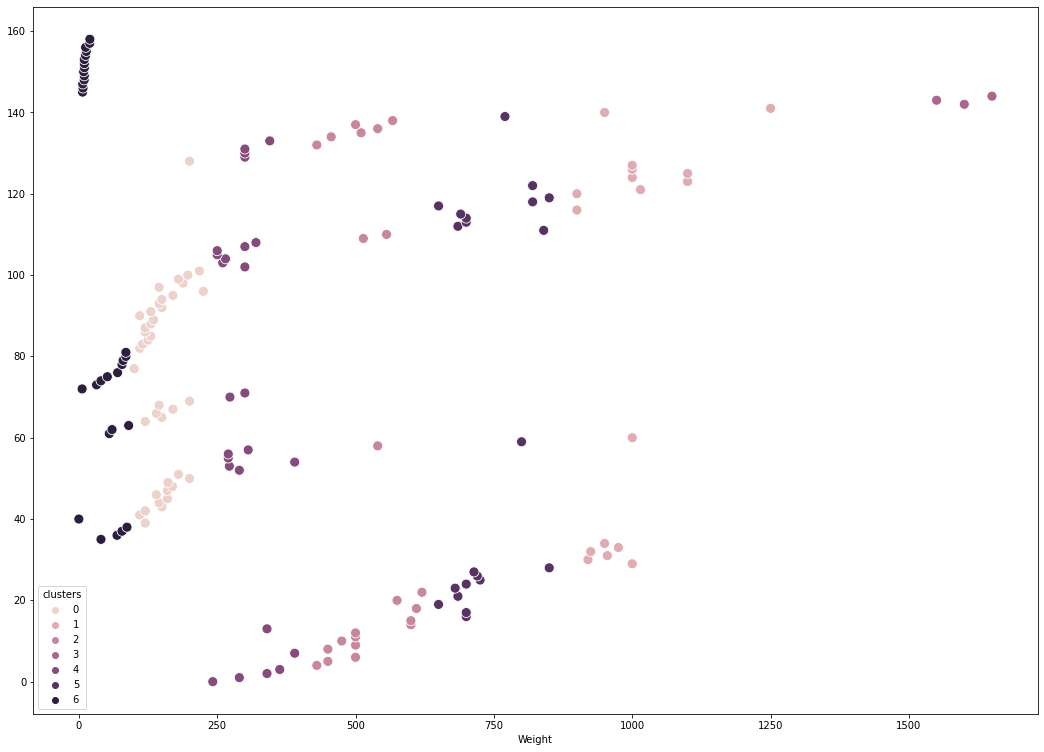

In [50]:
sns.scatterplot(data=df_, x="Weight", y=df_.index, hue="clusters", s=100)

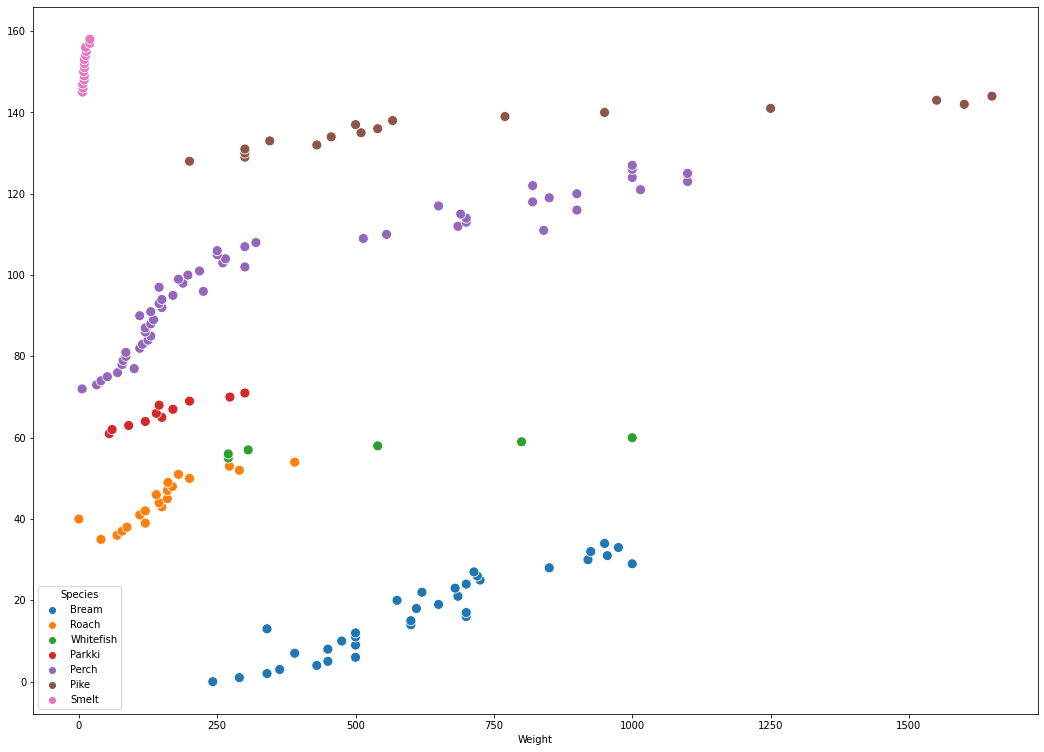

In [51]:
sns.scatterplot(data=df_, x="Weight", y=df_.index, hue="Species", s=100)

A olho nu, os clusters não foram muito precisos. A explicação mais plausível para isso é que:

- O que define a espécie do peixe não são apenas suas características físicas (peso, altura, comprimento e largura). Ou seja, um peixe da mesma espécie (que seria equivalente ao mesmo cluster), pode ter várias formas e tamanhos diferentes (óbvio que dentro de um intervalo ainda assim) e existem pesos, alturas, larguras e comprimentos iguais para peixes de diferentes espécies. Nosso modelo não identificou isso.

 Em compensação, os dados parecem terem sido colocados na base de fato de maneira não ordinária.


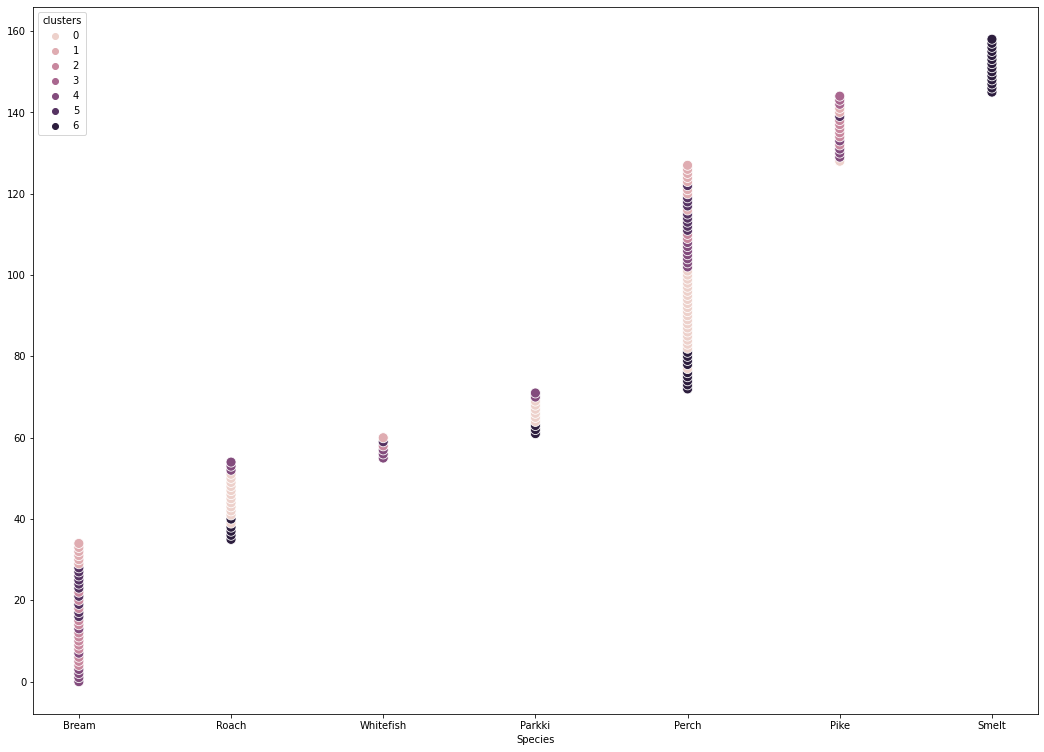

In [52]:
sns.scatterplot(data=df_, x="Species", y=df_.index, hue="clusters", s=100)

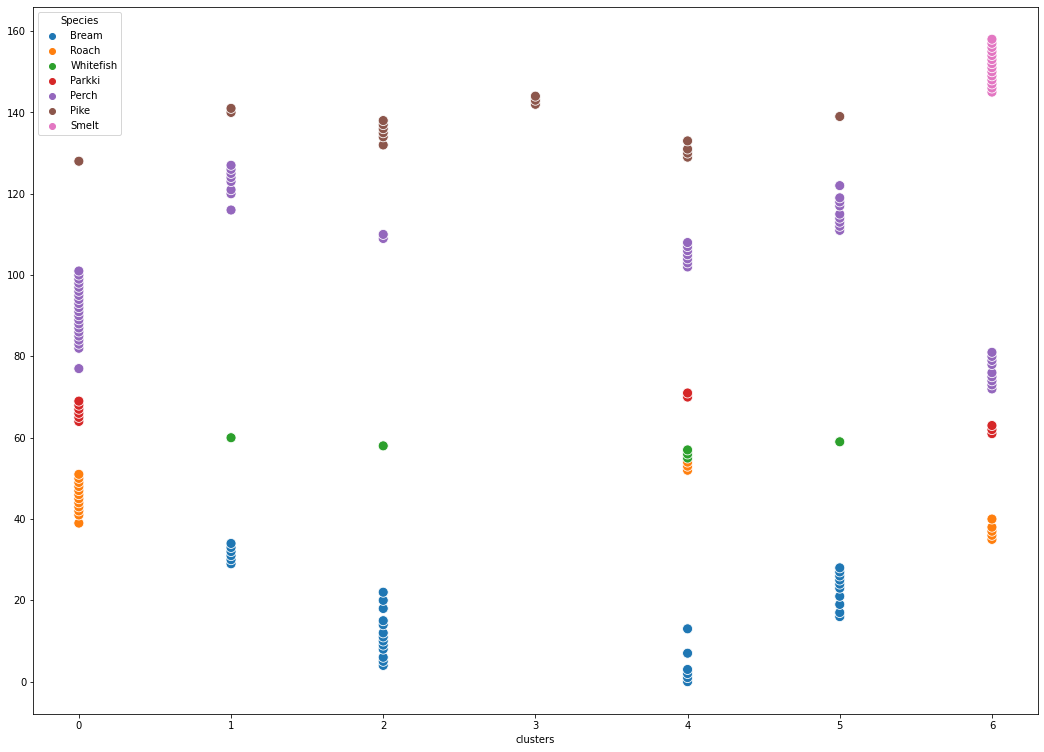

In [53]:
sns.scatterplot(data=df_, x="clusters", y=df_.index, hue="Species", s=100)

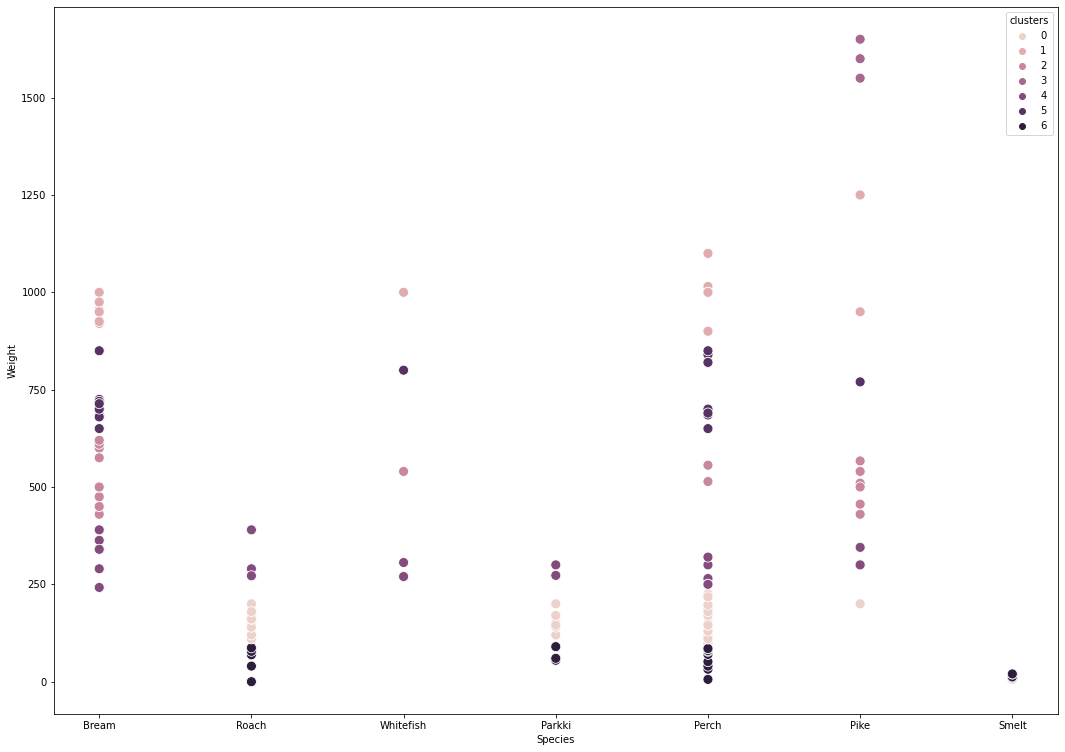

In [54]:
sns.scatterplot(data=df_, x="Species", y='Weight', hue="clusters", s=100)

O gráfico acima mostra muito claramente porquê o algoritmo não funcionou:

Vejamos os peixes até 250 unidades. Eles podem ser da espécie Roach, Parkki, Perch e Smelt. O algoritmo interpretou que peixes leves fariam parte de apenas uma espécie. Eu também achava isso.

Para que o algoritmo funcionasse melhor, ia ser bom ter mais informações dos peixes, ou seja, mais colunas.

Que interessante. Muito claramente nosso algoritmo separou os dados de maneira diferente. Seria melhor seguir com k = 3.

Para nossa análise:

- Bream = 0
- Roach = 1
- Whitefish = 2
- Parkki Species = 3
- Perch = 4
- Pike = 5
- Smelt = 6


In [55]:
print(df_.query('Species == "Bream"')['Weight'].max())
print(df_.query('Species == "Bream"')['Weight'].min())
print('----')
print(df_.query('clusters == 0')['Weight'].max())
print(df_.query('clusters == 0')['Weight'].min())

1000.0
242.0
----
225.0
100.0


Olha só, para o algoritmo, a espécie Bream tinha um mínimo e máximo para seu peso diferente da vida real. Inclusive, o fato de haver intersecções entre os pesos levou o algorimto a não performar tão bem:

In [56]:
lista = [['Bream', 0], ['Roach', 1], ['Whitefish', 2], ['Perch', 4], ['Pike', 5], ['Smelt', 6]]
for x in lista:
  print(f"{x[0]}: ")
  print(df_.query(f'Species == "{x[0]}"')['Weight'].max())
  print(df_.query(f'clusters == {x[1]}')['Weight'].max())

Bream: 
1000.0
225.0
Roach: 
390.0
1250.0
Whitefish: 
1000.0
620.0
Perch: 
1100.0
390.0
Pike: 
1650.0
850.0
Smelt: 
19.9
90.0


Percebamos como há divergência entre o máximo do peso das três espécies em exemplo acima com o que o algoritmo inferiu:

- Bream: máximo real de 1000, no algoritmo 850;
- Roach: máximo real de 390, no algoritmo 225;
- Whitefish: máximo real de 1000, no algoritmo 620;
- Perch: máximo real de 1100, no algoritmo 1250;
- Pike: máximo real de 1650, no algoritmo 390;
- Smelt: máximo real de 19.9, no algoritmo 90;

Além disso, como nas espécies Bream e Whitefish, por exemplo, havia muita intersecção entre os valores.

No fim, seria melhor seguir com o k = 3.